In [1]:
import os

import matplotlib.pyplot as plt

import librosa
import scipy
import scipy.signal as sig
import scipy.io.wavfile as scw

import numpy as np

import wave
import cmath as cm
import math

import default_settings


# preparation : define extract_feature.

In [2]:
def levinson(signal, order):
    x = signal
    p = order
    autocorr = np.correlate(x,x,mode='full')
    r = autocorr[len(x)-1:len(x)+p]

    a = np.zeros(p+1)
    k = np.zeros(p)
    a[0] = 1
    a[1] = -r[1] / r[0]
    k[0] = a[1]
    E = r[0] + r[1] * a[1]
    for q in range(1,p):
        k[q] = -np.sum(a[0:q+1] * r[q+1:0:-1]) / E
        U = a[0:q+2]
        V = U[::-1]
        a[0:q+2] = U + k[q] * V
        E *= 1-k[q] * k[q]

    return a, k


def preEmphasis(signal, p):
    return sig.lfilter([1.0, -p], 1, signal)


def autocorr(x, nlags=None):
    N = len(x)
    if nlags == None: nlags = N
    r = np.zeros(nlags)
    for lag in range(nlags):
        for n in range(N - lag):
            r[lag] += x[n] * x[n + lag]
    return r

In [3]:
def FFT(x):
    N = x.shape[0]
    
    # Recursive processing end confirmation
    if N==1:
        return x[0]
    
    x_even = x[0:N:2]
    x_odd = x[1:N:2]
    
    # Recursive processing
    X_even = FFT(x_even)
    X_odd = FFT(x_odd)
    
    # weight
    W = []
    for t in range(N//2):
        W.append(np.exp(-1j * ((2*np.pi*t) / N)))
    W = np.array(W)
    
    X = np.zeros(N, dtype="complex")
    X[0:N//2] = X_even + W*X_odd
    X[N//2:N] = X_even - W*X_odd
    
    return X


def IFFT(X):
    N = X.shape[0]
    X = X.conjugate()
    x = FFT(X)
    return (1/N) * x.conjugate()


In [4]:
def extract_formant(x, deg, fs=22050):
    a, k = levinson(x,deg)
    
    w, h = sig.freqz(1, a)
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #ax.plot(fs * w / 2.0 / np.pi, 20 * np.log10(np.abs(h)))
    #ax.set_xlabel('frequency [Hz]')
    #ax.set_ylabel('$1 / |A(e^{j\omega})|$ [dB]')
    #plt.show()
    
    poles = np.roots(a)
    intns = np.abs(poles)
    ff = np.angle(poles) * fs / 2.0 / np.pi
    formantfreq = ff[(ff > 10) & (ff < fs / 2.0 - 10) & (intns > 0.8)]

    return formantfreq


def extract_cepstrum(x, deg, fs=22050):
    fft_data_ori = FFT(x)
    freq_ori = np.arange(len(fft_data_ori)) * fs / len(fft_data_ori)
    pow_spec = np.log10(np.real(np.abs(fft_data_ori)**2))
    cep = IFFT(pow_spec)
    return cep[:deg]


def extract_mfcc(x, deg, fs=22050):
    if len(x) <= 2048:
        mfcc = librosa.feature.mfcc(y=x, sr=fs ,n_mfcc=deg, n_fft=len(x))
    else:
        mfcc = librosa.feature.mfcc(y=x, sr=fs ,n_mfcc=deg)
    mfcc = np.average(mfcc, axis = 1)
    
    mfcc = mfcc.flatten()
    mfcc = mfcc.tolist()
    
    mfcc.pop(0)
    mfcc = mfcc[:12]
    return mfcc


In [5]:
speech_sample_dir = default_settings.vowel_dir
output_features_dir = default_settings.features_dir
wav_files = os.listdir(speech_sample_dir)

fmt_dir = os.path.join(output_features_dir, 'fmt')
cep_dir = os.path.join(output_features_dir, 'cep')
mfcc_dir = os.path.join(output_features_dir, 'mfcc')

if not os.path.exists(fmt_dir):
    os.makedirs(fmt_dir)
if not os.path.exists(cep_dir):
    os.makedirs(cep_dir)
if not os.path.exists(mfcc_dir):
    os.makedirs(mfcc_dir)

In [6]:
# formant data
FORMANT = []
# label data
LABEL = []
# mfcc data
MFCC = []

for wav_file in wav_files[:]:
    basename_without_ext = os.path.splitext(os.path.basename(wav_file))[0]
    label = basename_without_ext.split('_')[0]
    fmt_file = os.path.join(fmt_dir, basename_without_ext + '_fmt')
    cep_file = os.path.join(cep_dir, basename_without_ext + '_cep')
    mfcc_file = os.path.join(mfcc_dir, basename_without_ext + '_mfcc')
    
    sampling_rate, sample_data = scw.read(os.path.join(speech_sample_dir, wav_file))
    sample_data = sample_data / 32768
    
    return_formant = extract_formant(sample_data, 12, sampling_rate)
    return_formant.sort()
    return_cep = extract_cepstrum(sample_data[:512], 20, sampling_rate)
    return_mfcc = extract_mfcc(sample_data, 20, sampling_rate)
    
    #np.save(fmt_file, return_formant)
    #np.save(cep_file, return_cep)
    #np.save(mfcc_file, return_mfcc)
    
    FORMANT.append(return_formant[:2])
    LABEL.append(label)
    MFCC.append(return_mfcc)
    

## speaker recognition

In [7]:
for data, label in zip(FORMANT, LABEL):
    print(data,label)

[359.82400534 957.03321564] a
[ 359.04451134 2021.66558281] e
[ 306.06734237 1747.6899365 ] u
[ 404.5496131  1014.30122892] a
[ 353.05055634 2194.33187911] e
[ 378.39392655 2262.51245728] e
[ 460.26505791 1058.80915514] a
[ 295.01135656 3636.52262072] i
[ 302.17198054 4147.16238536] u
[ 345.14825776 1058.46995357] a
[ 267.39156484 1817.82673725] i
[ 340.99985517 2188.00319044] e
[376.31457974 667.10529682] o
[ 320.26443745 1587.18932047] u
[332.92833882 690.6981292 ] o
[ 288.33943439 1942.22690858] i
[ 279.89810969 1904.97808096] i
[ 369.85989109 1962.99734326] e
[ 297.72149189 2132.6214949 ] i
[361.42282642 959.70773645] a
[ 319.42981491 4135.72748545] u
[350.7695197  719.98433291] o
[346.66673229 709.20542358] o
[ 323.52325619 2027.31644856] u
[350.17330499 651.90787812] o


## plot formant graph

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
a_x_data = []
i_x_data = []
u_x_data = []
e_x_data = []
o_x_data = []
a_y_data = []
i_y_data = []
u_y_data = []
e_y_data = []
o_y_data = []

for data, label in zip(FORMANT, LABEL):
    if label == 'a':
        a_x_data.append(data[0])
        a_y_data.append(data[1])
    elif label == 'i':
        i_x_data.append(data[0])
        i_y_data.append(data[1])
    elif label == 'u':
        u_x_data.append(data[0])
        u_y_data.append(data[1])
    elif label == 'e':
        e_x_data.append(data[0])
        e_y_data.append(data[1])
    elif label == 'o':
        o_x_data.append(data[0])
        o_y_data.append(data[1])


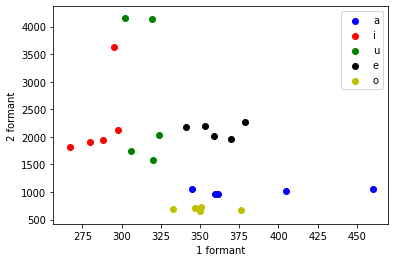

In [10]:
fig, ax = plt.subplots()

plt.xlabel('1 formant',fontsize=10)
plt.ylabel('2 formant',fontsize=10)
plt.scatter(a_x_data, a_y_data, label='a', c="b")
plt.scatter(i_x_data, i_y_data, label='i', c="r")
plt.scatter(u_x_data, u_y_data, label='u', c="g")
plt.scatter(e_x_data, e_y_data, label='e', c="k")
plt.scatter(o_x_data, o_y_data, label='o', c="y")

ax.legend()
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## One type of classification

In [28]:
only_label = []

for label in LABEL:
    if label != 'e':
        label = 'other'
    only_label.append(label)


In [29]:
x_only_train,x_only_test,y_only_train,y_only_test=train_test_split(FORMANT, only_label, train_size=0.8)
x_only_train = np.array(x_only_train)
x_only_test = np.array(x_only_test)
y_only_train = np.array(y_only_train)
y_only_test = np.array(y_only_test)

In [30]:
model = SVC(gamma='scale')
model.fit(x_only_train, y_only_train)

print('correct label = ', y_only_test)
print('predict label = ', model.predict(x_only_test))
print('correct answer rate = ', model.score(x_only_test, y_only_test))

correct label =  ['e' 'other' 'other' 'other' 'other']
predict label =  ['other' 'other' 'other' 'other' 'other']
correct answer rate =  0.8


## Formant vowel_recognition

In [9]:
## split feature data (use Formant) into 20 training data + 5 test data.

x_train,x_test,y_train,y_test=train_test_split(FORMANT, LABEL, train_size=0.8)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
## train SVM or logistic regression using the training data, and evaluate it with the test data.
model = SVC(gamma='scale')
model.fit(x_train, y_train)

print('correct label = ', y_test)
print('predict label = ', model.predict(x_test))
print('correct answer rate = ', model.score(x_test, y_test))

correct label =  ['u' 'e' 'u' 'i' 'i']
predict label =  ['u' 'e' 'e' 'e' 'e']
correct answer rate =  0.4


## MFCC vowel_recognition

In [11]:
## split feature data (use MFCC) into 20 training data + 5 test data.

x_train,x_test,y_train,y_test=train_test_split(MFCC, LABEL, train_size=0.8)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [12]:
## train SVM or logistic regression using the training data, and evaluate it with the test data.
model = SVC(gamma='scale')
model.fit(x_train, y_train)

print('correct label = ', y_test)
print('predict label = ', model.predict(x_test))
print('correct answer rate = ', model.score(x_test, y_test))

correct label =  ['i' 'u' 'a' 'o' 'e']
predict label =  ['i' 'u' 'a' 'o' 'e']
correct answer rate =  1.0


In [11]:
## make above 2 steps into one function.
def speaker_recognition(feature_dir, n_train=20, n_test=5):
    return accuracy_train, accuracy_test

In [ ]:
## perform cross validation i.e. n_train=24, n_test=1, 
## and take average of accuracies of all 25 combinations.